# Model complexity
#### Introduction to Data Science 2020. Lecture 3. 
#### Sep, 14. Mikhail Belyaev
 - Two sides of one coin: train data fit & generalization.
 - How different types of errors depend on model complexity ...
 - ... and the size of the training sample?
 - How can we control the complexity of a linear model?
 - Bias-variance tradeoff.
 - A modern view on generalization curves.



In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
%matplotlib inline

## Polynomial example

Consider the following polynomial function
$$ f(x) = x - 0.5  x^2 - x^3 + 0.6 x^4$$

In [10]:
def f_poly(x, coefs=[1, -0.5, -1, 0.6]):
    summands = [x**(power+1) * coef for power, coef in enumerate(coefs)]
    return np.array(summands).sum(0)

We generate a dataset using this function adding random noise to make the dataset more realistic

In [11]:
def get_polynomial_data(sample_size, input_sampling='random', noise_std=0.1):
    """The function generates input and output data using the above-defined f_poly function"""
    
    if input_sampling=='random':
        X = np.random.rand(sample_size, 1) * 2 - 1
    elif input_sampling=='uniform':
        X = np.linspace(-1, 1, sample_size)[:, np.newaxis]
    else:
        raise ValueError('input_sampling must be random or uniform')
    
    y = f_poly(X)
    y += np.random.randn(*y.shape) * noise_std
    return X, y

In [12]:
def plot_results(model=None):
    plt.plot(*get_polynomial_data(100, 'uniform', 0), label='Original function')
    plt.plot(X, y, '.r', label='Training data')
    if model is not None:
        plt.plot(X_test, model.predict(X_test), '--g', label='Prediction')
    plt.legend()
    plt.ylim([-0.7, 0.5]) 

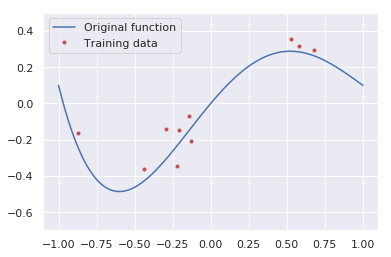

In [13]:
X, y = get_polynomial_data(10, noise_std=0.1)
X_test, y_test = get_polynomial_data(100, 'uniform')
plot_results()

#### A pipeline for a polynomial fit
A polynomial regression model seems to be a good choice for many low-dimensional problems. In our case the underlying function (usually unknown) is also a polynomial one.

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

How to create polynomial features?
 - Manually
 - Using PolynomialFeatures from sklearn.preprocessing

In [15]:
# manual:
X_poly = np.concatenate([X, X**2, X**3, X**4], axis=1)
print(X_poly.shape) 

# using the transformer:
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)
print(X_poly.shape) 

(10, 4)
(10, 4)


There are no parameters to fit in PolynomialFeatures, but sklearn requires to "fit" it in order to have the same interfaces for all transformers. 

In [16]:
# let us try to use PolynomialFeatures without fitting
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.transform(X)

NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

The key problem with the both ways to generate features is that we need to repeat this step (and other preprocessing steps if any) during prediction

In [45]:
# fit a linear model
model = LinearRegression()
X_poly = poly.fit_transform(X)
model.fit(X_poly, y)

# this line will return an error
# model.predict(X_test)
X_test_poly = poly.transform(X_test)
model.predict(X_test_poly);

There is a way to merge several steps into a single model

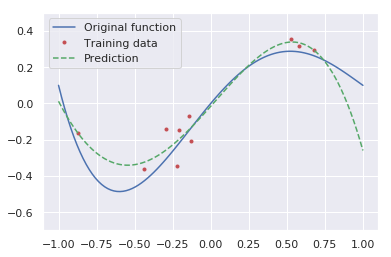

In [18]:
model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
model.fit(X, y); 
y_pred = model.predict(X_test)
plot_results(model)

## Lecture 2 follow-up: quality metrics for regression

 Usually we have $\left \{x_i, y_i \right \}_{i=1}^n$ - a sample (train / test) and $f()$ - our model.
 
 **How can we measure the quality of our model?**

 $$MSE = \frac{1}{n}\sum_{i=1}^n \left(y_i-f\left(x_i\right)\right)^{2}$$
 Issues: (1) nonintuitive units (e.g., error in $rubles^2$), (2) does not provide relative error.

**How can we measure the quality of our model?**

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n  \left(y_i-f\left(x_i\right)\right)^{2}}$$
$$MAE = \frac{1}{n}\sum_{i=1}^n  \left|y_i-f\left(x_i\right)\right|$$
 
 Issues: ~~(1) nonintuitive units~~, (2) do not provide relative error.

**How can we measure the quality of our model?**

$$R^2 = 1 - \frac{\sum_i \left(y_i-f\left(x_i\right)\right)^{2}}{\sum_i \left(y_i-\bar y\right)^{2}}
=
1 - \frac{MSE}{MSE_{const}}
$$
 
 Issues: ~~(1) nonintuitive units, (2) do not provide relative error.~~

**How can we measure the quality of our model?**

In [47]:
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import mean_squared_error as mae
from sklearn.metrics import r2_score as r2

def print_metrics(y_true, y_pred, prefix):
    print(f'{prefix} MSE', mse(y_true, y_pred))
    print(f'{prefix} RMSE', mse(y_true, y_pred)**0.5)
    print(f'{prefix} MAE', mae(y_true, y_pred))
    print(f'{prefix} R2', r2(y_true, y_pred))

In [48]:
def fit_print_plot(model):
    model.fit(X, y);
    print(f'Train R2:', r2(y, model.predict(X)))
    print(f'Test R2:', r2(y_test, model.predict(X_test)))
    plot_results(model)

### Two sides of one coin: train data fit & generalization.


Train R2: 0.9445607366055178
Test R2: 0.7923452031882883


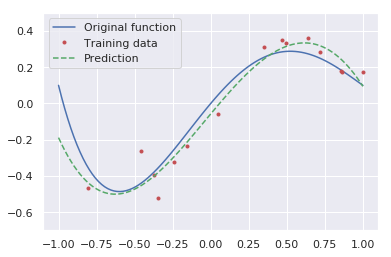

In [49]:
model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
fit_print_plot(model) 

In [50]:
y_train_pred = model.predict(X)
print_metrics(y, y_train_pred, 'Train')

Train MSE 0.05728390128631613
Train RMSE 0.2393405550388737
Train MAE 0.005589665868008734
Train R2 0.9445607366055178


In [23]:
y_test_pred = model.predict(X_test)
print_metrics(y_test, y_test_pred, 'Test')

Test MSE 0.11715758786681466
Test RMSE 0.3422829061855334
Test MAE 0.02230774019642555
Test R2 0.7325982544668819


###  How different types of errors depend on model complexity ...

Train R2: 0.0
Test R2: -0.00011123684116798316


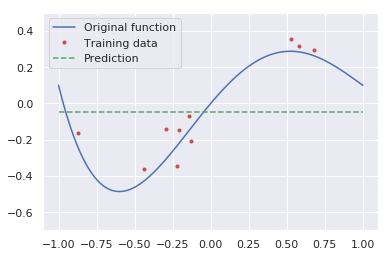

In [24]:
model = make_pipeline(PolynomialFeatures(degree=0), LinearRegression())
fit_print_plot(model)

Train R2: 0.9300120414076432
Test R2: 0.7325982544668819


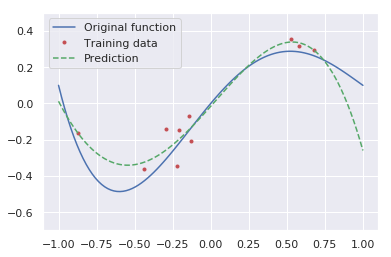

In [25]:
model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
fit_print_plot(model) 

Train R2: 0.9931602524408084
Test R2: -3425.3581210879483


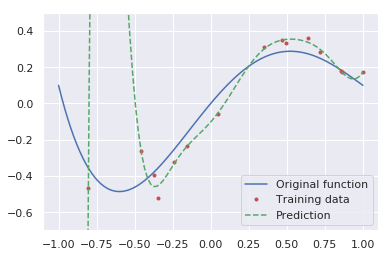

In [55]:
model = make_pipeline(PolynomialFeatures(degree=10), LinearRegression())
fit_print_plot(model)
# plt.ylim([-2, 2])

#### Let us calculate & plot two errors as functions of *degree*

(0, 0.3)

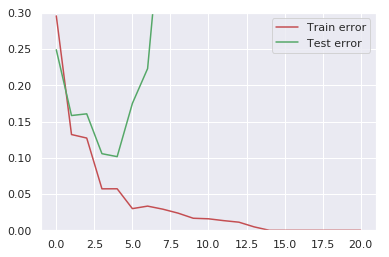

In [58]:
degree_range = range(0, 21) # 1, 2, ..., 20
errors_train = []
errors_test = []
for degree in degree_range:
    # initialize & fit the model
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    model.fit(X, y);
    
    errors_train.append(mse(y, model.predict(X)))
    errors_test.append(mse(y_test, model.predict(X_test)))

plt.plot(degree_range, errors_train, 'r', label='Train error')
plt.plot(degree_range, errors_test, 'g', label='Test error')
plt.legend()
plt.ylim([0, 0.3])

Why does the test error is so high for large values of `degree`?

1. There are to much features -> the model is too complex for this training sample.
2. In this toy example we can simply reduce the number of features, but what to do in a real problem?
3. There are two ways:
 - drop some features (will be discussed in lecture 6)
 - use regularization!

###  How different types of errors depend on the size of the training sample?

#### Can we use more complex models if we have more data?

Train R2: 0.9783780225591991
Test R2: -1.9771635603027113


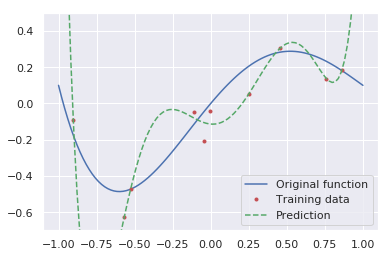

In [68]:
model_too_complex = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
fit_print_plot(model_too_complex)

In [70]:
X, y = get_polynomial_data(50, noise_std=0.1)

Train R2: 0.867642254562515
Test R2: 0.867165996499534


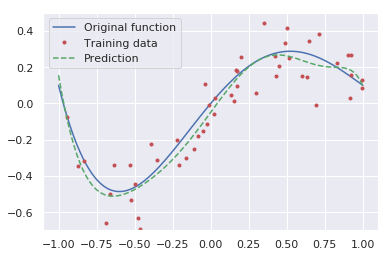

In [71]:
model_just_right = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
fit_print_plot(model_just_right)

(0, 0.2)

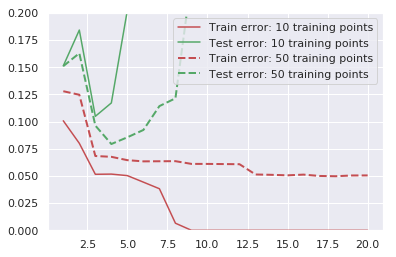

In [31]:
errors_train_more_data = []
errors_test_more_data = []
for degree in degree_range:
    # initialize & fit the model
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    model.fit(X, y);
    errors_train_more_data.append(mse(y, model.predict(X)))
    errors_test_more_data.append(mse(y_test, model.predict(X_test)))

plt.plot(degree_range, errors_train, 'r', label='Train error: 10 training points')
plt.plot(degree_range, errors_test, 'g', label='Test error: 10 training points')

plt.plot(degree_range, errors_train_more_data, '--r', lw=2, label='Train error: 50 training points')
plt.plot(degree_range, errors_test_more_data, '--g', lw=2, label='Test error: 50 training points')
plt.legend()
plt.ylim([0, 0.2])

###  How can we control the complexity of a linear model?


#### What's the difference between a too complex model and a just right complexity?

Train R2: 0.9826729044872723
Test R2: -966.6038189401329


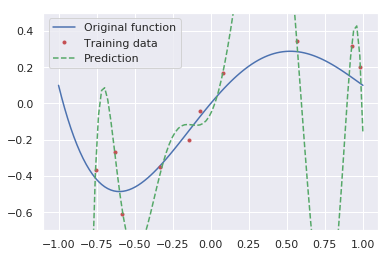

In [84]:
X, y = get_polynomial_data(10, noise_std=0.1)

model_too_complex = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
fit_print_plot(model_too_complex)

Train R2: 0.867642254562515
Test R2: 0.867165996499534


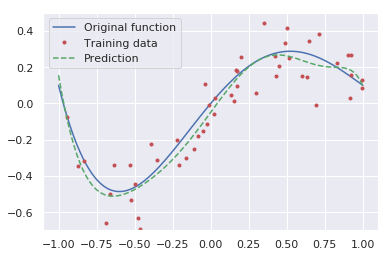

In [74]:
fit_print_plot(model_just_right)

In [81]:
model_just_right

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=8)),
                ('linearregression', LinearRegression())])

In [85]:
lr = model_too_complex.steps[1][1]
print(lr.coef_) 

[[   0.            1.69253202   13.261858     20.21212137  -92.9930726
  -107.53138534  208.1448311   114.24653453 -157.14517542]]


In [83]:
lr = model_just_right.steps[1][1]
print(lr.coef_) 

[[ 0.          1.1469903   0.01230048 -2.17886497 -1.70482498  2.5550262
   3.31485172 -1.55293329 -1.44744374]]


#### Can we somehow limit the coefficients?

#### Yes, we can!

**Solution 1:** ridge regression
$$
  \min_{\beta} \sum_{i = 1}^N (y^i - \beta^T \mathbf{x}^{i})^2 + \lambda \|\beta\|_2^2.
$$

An equal form of this problem is

$$
  \min_{\|\beta\|_2^2 \le \hat \lambda } \sum_{i = 1}^N (y^i - \beta^T \mathbf{x}^{i})^2. 
$$

**Solution 2:** LASSO
$$
  \min_{\beta} \sum_{i = 1}^N (y^i - \beta^T \mathbf{x}^{i})^2 + \lambda \|\beta\|_1,
$$
where $\|\beta\|_1 = \sum_{j = 1}^p |\beta_j|$.

### Geometrical illustration

![alt text](https://1.bp.blogspot.com/-tXq6Nl2lcNg/V3qzttiZ4sI/AAAAAAAAN_M/6nmjgwydWJUy5Kqt9gFg2Nb12BCTcD4ogCLcB/s1600/LASSO.png "Lasso vs Ridge")

### Now we can constrain our coefficients to control the complexity of our model

In [37]:
from sklearn.linear_model import Ridge, Lasso

Train R2: 0.8616057187354526
Test R2: -24.69375586836634

Train R2: 0.6701242579015888
Test R2: 0.8363813829004383


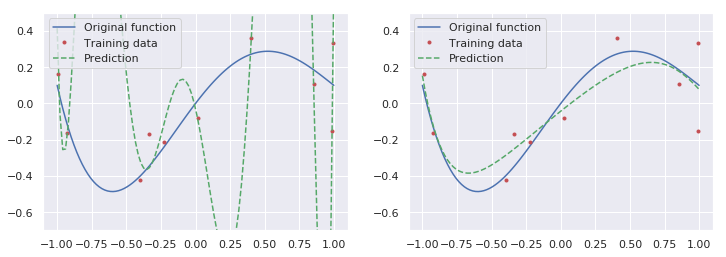

In [88]:
# X, y = get_polynomial_data(10, noise_std=0.1)

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
model_too_complex = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
fit_print_plot(model_too_complex)

plt.subplot(1, 2, 2)
model_too_complex = make_pipeline(PolynomialFeatures(degree=8), Ridge(alpha=1e-1))
print(); fit_print_plot(model_too_complex)

(0, 0.3)

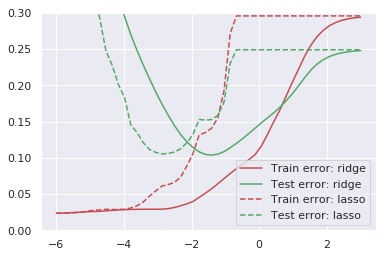

In [39]:
alpha_range = np.linspace(-6, 3)
mse_ridge_train, mse_ridge_test = [], []
mse_lasso_train, mse_lasso_test = [], []
for alpha in alpha_range:
    # initialize & fit the model
    ridge = make_pipeline(PolynomialFeatures(degree=8), Ridge(alpha=10**alpha))
    ridge.fit(X, y);
    mse_ridge_train.append(mse(y, ridge.predict(X)))
    mse_ridge_test.append(mse(y_test, ridge.predict(X_test)))
    
    lasso = make_pipeline(PolynomialFeatures(degree=8), Lasso(alpha=10**alpha, max_iter=1e7))
    lasso.fit(X, y);
    mse_lasso_train.append(mse(y, lasso.predict(X)))
    mse_lasso_test.append(mse(y_test, lasso.predict(X_test)))
    
plt.plot(alpha_range, mse_ridge_train, 'r', label='Train error: ridge')
plt.plot(alpha_range, mse_ridge_test, 'g', label='Test error: ridge')

plt.plot(alpha_range, mse_lasso_train, '--r', label='Train error: lasso')
plt.plot(alpha_range, mse_lasso_test, '--g', label='Test error: lasso')
plt.legend()
plt.ylim([0, 0.3])

### We can now comapre coefficients for the optimal complexity

In [40]:
linear = make_pipeline(PolynomialFeatures(degree=8), LinearRegression())
linear.fit(X, y)
ridge = make_pipeline(PolynomialFeatures(degree=8), Ridge(alpha=10**-2))
ridge.fit(X, y)
lasso = make_pipeline(PolynomialFeatures(degree=8), Lasso(alpha=10**-3.5, max_iter=1e7))
lasso.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=8)),
                ('lasso',
                 Lasso(alpha=0.00031622776601683794, max_iter=10000000.0))])

In [41]:
print(linear.steps[1][1].coef_) 

[[  0.           0.85147412  -1.28458361   5.20095511   8.18165005
  -37.86019319   7.61676399  44.44542584 -26.91604093]]


In [42]:
print(ridge.steps[1][1].coef_)

[[ 0.          1.00752497  0.26803668 -0.9280069  -0.50495598 -0.19925131
  -0.16580674  0.40956728  0.34918378]]


In [43]:
print(lasso.steps[1][1].coef_)

[ 0.          1.07940259  0.23362119 -1.26715333 -0.43132792  0.
 -0.          0.61851631  0.        ]



### Bias Variance Decomposition

### Linear model

-   In the standard Gaussian, parametized by mean and variance.

-   Make the mean a linear function of an *input*.

-   This leads to a regression model. 
    \begin{align*}
       y_i=&f\left(x_i\right)+\epsilon_i,\\
       f\left(x\right) =& mx + c\\
         \epsilon_i \sim &\mathcal{N}(0, \sigma^2).
     \end{align*}



The expected test error for different variations of the *training data* sampled from, $\Pr(\mathbf{x}, y)$

$$\mathbb{E}\left[ (y - \hat{f}(\mathbf{x}))^2 \right].$$

Decomposed as

$$\mathbb{E}\left[ (y - \hat{f}(\mathbf{x}))^2 \right] = \text{bias}\left[\hat{f}(\mathbf{x})\right]^2 + \text{variance}\left[\hat{f}(\mathbf{x})\right] +\sigma^2.$$

See the proof [here](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html).

### Bias

- Given by
    $$\text{bias}\left[\hat{f}(\mathbf{x})\right] = \mathbb{E}\left[\hat{f}(\mathbf{x})\right] - f(\mathbf{x}).$$
    
- Error due to bias comes from a model that's too simple.

### Variance

- Given by
    $$\text{variance}\left[\hat{f}(\mathbf{x})\right] = \mathbb{E}\left[\left(\hat{f}(\mathbf{x}) -  \mathbb{E}\left[\hat{f}(\mathbf{x})\right]\right)^2\right].$$
    
- Slight variations in the training set cause changes in the prediction. Error due to variance is error in the model due to an overly complex model. 

# Bias-variance tradeoff

![alt text](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png "Bias-variance tradeoff")

Check a great tutorial http://scott.fortmann-roe.com/docs/BiasVariance.html

![alt text](https://miro.medium.com/max/653/1*Y-yJiR0FzMgchPA-Fm5c1Q.jpeg "Bias-variance tradeoff")

Check a great tutorial http://scott.fortmann-roe.com/docs/BiasVariance.html

####  Let us compare it with a real graph

(0, 0.2)

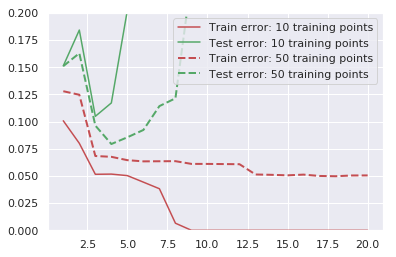

In [44]:
plt.plot(degree_range, errors_train, 'r', label='Train error: 10 training points')
plt.plot(degree_range, errors_test, 'g', label='Test error: 10 training points')
plt.plot(degree_range, errors_train_more_data, '--r', lw=2, label='Train error: 50 training points')
plt.plot(degree_range, errors_test_more_data, '--g', lw=2, label='Test error: 50 training points')
plt.legend(); plt.ylim([0, 0.2])

#### To try at home: design the experiment to estimate Bias and Variance rather than Train & Test errors

#### Some real models do not correspond to these type of curves at all, for example neural networks. 

There are new concepts, for example


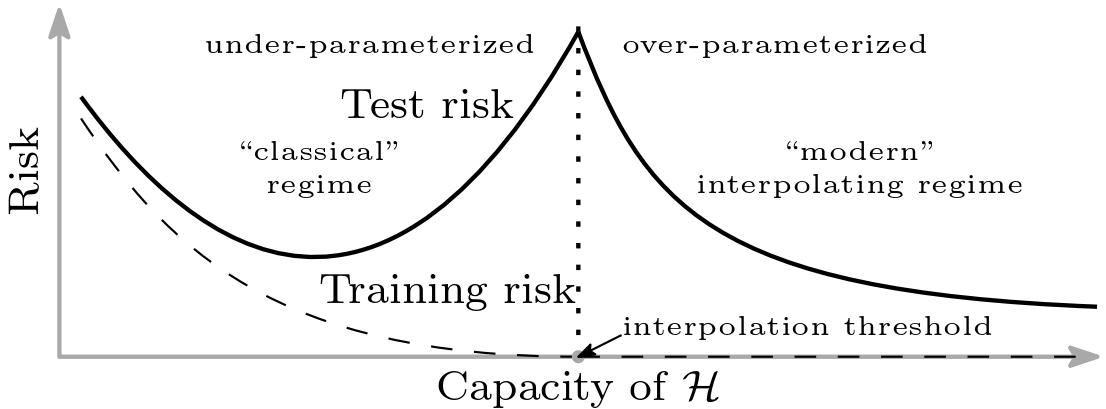


For more details, see this [overview](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update)

## Regression with Nearest Neighbours

### 1-Nearest Neighbour
* Keep the whole training dataset: ${(x, y)}$.
* A query example (vector) $q$ comes
* Find closest example(s) $x^*$.
* Predict $y^*$.

### K-Nearest Neighbours
* **Problem:** one neighbour can give unstable predictions.
* **Solution:** take $k$ nearest neighbours.
* **Output**:  the average target variable among $k$ nearest neighbors (may be a weighted average).

![image](./knn.png)

#### What is the measure of complexity for this model?